# CNN model notebook

Import libraries and modules

In [1]:
# move to the root directory of the git
%cd ..

C:\Users\DJNaj\Documents\CiTG\MSc\Year II\Q2\CEGM2003 - Data Science and Artificial Intelligence for Engineers\Unit 3 - Project\FLOOD_group2


In [2]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import io
import imageio.v2 as imageio 
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import random_split
import torch.nn as nn
from torchsummary import summary
from torchviz import make_dot
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from matplotlib.colors import TwoSlopeNorm
import random
from IPython.display import Image, display
import time

from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.process_data import *
from post_processing.plots import create_combined_gif
from models.CNN_model.CNN_functions import *
from models.CNN_model.CNN_classes import *
from pre_processing.augmentation import *
from pre_processing.normalization import * 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Creating Training Dataset

First the training dataset is created based upon a research paper by Bentivoglio et al (2023). For training and validation purposes a dataset of 80 different generated digital elevation models are used to reflect different plausible topographies. The velocity in both x and y direction (VX and VY) as well as the water depth (WD) are known, based on numerical computations utilizing Delft3D.

The code cell below uses the decode_from_csv function to load in the datasets and pre-process them. For further information of the encode/decode csv method please refer to the pre-processing folder. Its main purpose is to reduce the loading time of the dataset. 
However, as this method was originally developed mainly for the ConvLSTM model (which also uses discharge as a target), the code needed some adapting to implement it in this CNN model. The CNN models uses a single target, namely the water depth. This is why the remove_discharge function is used to remove the discharge from the target tensor.

The main steps in the pre-processing step include:

<b>Elevation Data Processing</b>

The process_elevation_data function takes a DEM (Digital Elevation Model) file identifier (file_id) and a dataset identifier (dataset_id) as inputs. It reads the corresponding DEM file, extracts elevation data, and calculates the slope in the x and y directions. The result is a torch tensor combining the original elevation data with its slope information.

<b>Water Depth Processing</b>

The process_water_depth function processes water depth data from a specific time step in a file. It requires a water depth file identifier (file_id), a dataset identifier (dataset_id), and an optional time step parameter (time_step, default is 0). The function reads the specified file, extracts the data for the given time step, and returns a 64x64 torch tensor representing water depth.

Note that the remove_discharge function is used to remove the discharge from the targets, as this CNN model uses a single target, namely the water depth. The CONV-LSTM model does use discharge as a target, which is why it nee

In [4]:
def remove_discharge(train_val_test):
    '''
    Print is located within decode_csv
    '''
    dataset = decode_from_csv(train_val_test)
    inputs = dataset[:][0]
    targets = dataset[:][1]
    targets = targets[:,:, 0].unsqueeze (2) # remove discharge
    new_dataset = TensorDataset(inputs.float(), targets.float())
    return new_dataset
train_dataset = remove_discharge('train_val')

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


# Creating the Test Dataset

Now the test dataset is created based on dataset1 from Bentivoglio et al (2023). This dataset features 20 DEMs over a squared domain of 64x64 grids of length 100 m and a simulation time of 48 h. A fixed breach location is used.

In [5]:
test_dataset1 = remove_discharge('test1')
test_dataset2 = remove_discharge('test2')

Restored inputs Shape: torch.Size([20, 1, 4, 64, 64])
Restored targets Shape: torch.Size([20, 48, 2, 64, 64])
Restored inputs Shape: torch.Size([21, 1, 4, 64, 64])
Restored targets Shape: torch.Size([21, 48, 2, 64, 64])


# Aplying Data augmentation

Below data augmentation is applied to increase the size of a training dataset. The implemented data augmentation methods include rotation and horizontal flipping.

In [6]:
transformed_dataset = augmentation(train_dataset)

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 560


# Splitting the Datasets

Below, the training dataset is split into training and validation sets. A standard 80/20 split is employed. 

In [7]:
# Split dataset into train and validation
random_gen = torch.Generator().manual_seed(42) # find a random seed and fix it to always have the same split

train_percent = 0.8
train_size = int(train_percent * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_dataset, val_dataset = random_split(transformed_dataset, [train_size, val_size], random_gen)

# Model summary and visualization

Now the CNN model is instantiated and a summary of the model is printed. Please refer to the '‘CNN_classes.py’' file within the CNN_model directory for further details on the defining of the CNN architecture. The model resembles a U-Net, consisting of an encoder and a corresponding decoder, connected by a bottleneck layer. In total, the model has 124,128,688 parameters, all of which are trainable.
The key components of the model architecture are:


<b>Encoder</b>

The encoder consists of multiple layers of convolution and pooling operations, gradually reducing spatial dimensions while increasing feature channels:

•	The model starts with a convolutional layer (Conv2d-1) followed by batch normalization (BatchNorm2d-2) and Rectified Linear Unit (ReLU-3).

•	This is followed by another set of convolution, batch normalization, and ReLU (DoubleConv-7).

•	Max pooling (MaxPool2d-8) is applied to reduce spatial dimensions.

•	The model then repeats the encoder structure, gradually increasing the number of channels in each block (Down-16, Down-25, Down-35).


<b>Decoder</b>

The decoder, comprised of up-sampling and convolutional layers, reconstructs the high-resolution segmentation map from the learned features:

•	The decoder begins with upsampling using transposed convolution (ConvTranspose2d-44) followed by a series of convolution, batch normalization, and ReLU operations (DoubleConv-51).

•	This process is repeated for each level of the decoder (Up-52, Up-61, Up-70, Up-79).


<b>Skip connections</b>

Skip connections are established between corresponding encoder and decoder layers, which enhance information flow between different resolutions; facilitating the preservation of fine details and improving the training stability.

In [8]:
# Instantiate the CNN
model = UNet().to(device)
summary(model, input_size=(4, 64, 64)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 64, 64]           4,608
       BatchNorm2d-2          [-1, 128, 64, 64]             256
              ReLU-3          [-1, 128, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]         147,456
       BatchNorm2d-5          [-1, 128, 64, 64]             256
              ReLU-6          [-1, 128, 64, 64]               0
        DoubleConv-7          [-1, 128, 64, 64]               0
         MaxPool2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 32, 32]         294,912
      BatchNorm2d-10          [-1, 256, 32, 32]             512
             ReLU-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         589,824
      BatchNorm2d-13          [-1, 256, 32, 32]             512
             ReLU-14          [-1, 256,

Below, the model architecture is visualized using PyTorchViz. To turn on the visualization, make sure 

<code>visualize = True</code>

PyTorchViz uses the following color-coding the model architecture graph:

•	Blue nodes represent tensors or variables in the computation graph. These are the data elements that flow through the operations.

•	Gray nodes represent PyTorch functions or operations performed on tensors.

•	Green nodes represent gradients or derivatives of tensors. They showcase the backpropagation flow of gradients through the computation graph.

In [9]:
visualize = False

if visualize == True:
    # Visualize the model architecture
    dummy_input = torch.randn(1, 4, 64, 64).to(device)
    model.eval()  # Set the model to evaluation mode
    out = model(dummy_input)
    graph = make_dot(out, params=dict(model.named_parameters()))
    output_path = os.path.join('images', 'CNN_model_graph')
    graph.render(output_path, format="png", cleanup=True)
    img_path = f"{output_path}.png"
    display(Image(filename=img_path))

# Model training

<b>Training Parameters</b>

First the learning rate, batch size, and the number of training epochs are specified.

In [10]:
# Set training parameters
learning_rate = 0.001
batch_size = 8
num_epochs = 100

<b>Optimizer and Dataloaders</b>

An Adam optimizer is set up to train the neural network, and dataloaders are created to efficiently handle batches of data during training and evaluation.

In [11]:
# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

<b>Training and Evaluation Loops</b>

Here, we iterate over epochs, conducting both training and validation loops. Losses are computed and stored for each epoch, with periodic printing for monitoring. Early stopping is implemented to prevent overfitting and improve the generalization performance of a model.

The code cell below uses two custom functions for training and evaluating:

<b>train_epoch</b>

The train_epoch function is used for training the model. It takes as input the model architecture (model), a data loader (loader) supplying training batches, an optimizer (optimizer) for weight updates, and the computation device (device). During each training epoch, the function iterates through the provided data loader, performs forward and backward passes, computes Mean Squared Error (MSE) loss, and updates the model parameters using backpropagation.

<b>evaluation</b>

The evaluation function is used for assessing the model's performance on a validation or test dataset. Similar to train_epoch, it takes the model (model), a data loader (loader), and the computation device (device) as inputs. However, it operates in evaluation mode, meaning it disables gradient computation and only performs forward passes to compute MSE loss on the validation or test set.

In [12]:
def train_epoch(model, loader, optimizer, device):
    model.to(device)
    model.train() # specifies that the model is in training mode

    losses = []

    for batch in loader:
        x = batch[0]
        x = x[:, 0] # remove time step
        y = batch[1]
        y = y[:, :, 0] # remove part of the model that says singular feature
        x, y = x.float().to(device), y.float().to(device)
        # Model prediction
        preds = model(x)

        # MSE loss function
        loss = nn.MSELoss()(preds, y)

        losses.append(loss.cpu().detach())

        # Backpropagate and update weights
        loss.backward()   # compute the gradients using backpropagation
        optimizer.step()  # update the weights with the optimizer
        optimizer.zero_grad(set_to_none=True)   # reset the computed gradients

    losses = np.array(losses).mean()

    return losses


def evaluation(model, loader, device):
    model.to(device)
    model.eval() # specifies that the model is in evaluation mode

    losses = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            x = x[:, 0] # remove time step
            y = batch[1]
            y = y[:, :, 0] # remove part of the model that says singular feature
            x, y = x.float().to(device), y.float().to(device)

            # Model prediction
            preds = model(x)

            # MSE loss function
            loss = nn.MSELoss()(preds, y)
            losses.append(loss.cpu().detach())

    losses = np.array(losses).mean()

    return losses

In [13]:
train_losses = []
validation_losses = []

best_validation_loss = float('inf')  # Initialize with a very large value
patience = 25  # Number of epochs with no improvement after which training will be stopped

start_time = time.time()  # Record the start time

for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f}')

    # Check for early stopping
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        patience_counter = 0  # Reset patience counter since there is an improvement
    else:
        patience_counter += 1  # No improvement, increase the patience counter

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch+1} | Best Validation Loss: {best_validation_loss:.4f}')
        break  # Stop training

end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time

print(f'Total time taken: {elapsed_time:.2f} seconds')

Total time taken: 112.90 seconds


<b> Test Set Evaluation and Loss Plotting</b>

Below, the test loss is printed for the first and second test datasets.

In [14]:
test_loss_1 = evaluation(model, test_loader1, device=device)
test_loss_2 = evaluation(model, test_loader2, device=device)
print('Test Loss using test dataset 1:', test_loss_1)
print('Test Loss using test dataset 2:', test_loss_2)

Test Loss using test dataset 1: 5295226400.0
Test Loss using test dataset 2: 2601414000.0


Below, the training and validation losses are plotted over epochs to visualize the learning progress.

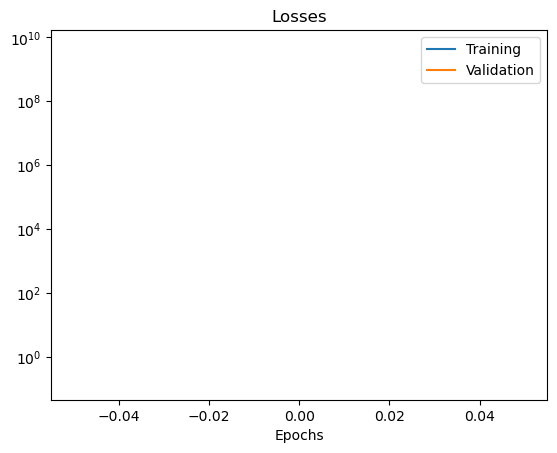

In [15]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Predicting Water Depth

Now that the model has been trained on the training dataset, it is used to make predictions of the water depth on unseen topographies using the test datasets. The predict_and_compare function is implemented to facilitate using different testing datasets. 

<b>predict_and_compare</b>

This function takes a model, a dataset, a specific data ID, and a starting time step (t0) as input parameters. It then predicts water depth using the given model and compares the predictions with the ground truth.

It returns the following NumPy arrays:

•	x_np represents the input data.

•	WD_np represents the ground truth water depth.

•	pred_WD_np represents the predicted water depth by the model.

These variables are used to visualize the results in the next section.

In [16]:
def predict_and_compare(model, dataset, data_id, t0, device='cuda'):
    # select one sample
    x = dataset[data_id][0][0].float().unsqueeze(0).to(device)
    WD = dataset[data_id][1].squeeze(1)

    # Display the shapes of the input data and water depth tensor
    print(f"Shape of input data (x): {x.shape}")
    print(f"Shape of water depth (WD): {WD.shape}")

    # Define the input tensor (x)
    x_np = x.squeeze(0).cpu().numpy()  # Convert tensor to NumPy array and remove the batch dimension

    # Define the WD tensor
    WD_np = WD.cpu().numpy()  # Convert tensor to NumPy array

    # Assuming WD is a sequence of images (96 time steps)
    num_time_steps = WD_np.shape[0]

    # Plotting specific time steps (e.g., every 10th time step)
    time_steps_to_plot = list(range(0, num_time_steps, 10))

    # predict the WD
    pred_WD = model(x).detach()

    # Convert the predicted tensor to numpy array
    pred_WD_np = pred_WD.squeeze(0).cpu().numpy()  # Assuming batch dimension needs to be squeezed

    return x_np, WD_np, pred_WD_np

Below, the predict_and_compare function is called using test_dataset1 and test_dataset2, respectively.

In [17]:
x_np1, WD_np1, pred_WD_np1 = predict_and_compare(model, test_dataset1, data_id=7, t0=0, device='cuda')
x_np2, WD_np2, pred_WD_np2 = predict_and_compare(model, test_dataset2, data_id=7, t0=0, device='cuda')

AssertionError: Torch not compiled with CUDA enabled

# Visualization

Now the results are visualized. The plots below are made using the create_combined_gif function, which creates a combined GIF with multiple subplots for the actual, predicted, and difference arrays, along with a subplot for the DEM map. It visualizes the evolution of these arrays over time.

The subplots include:

•	Subplot 1: DEM Map

•	Subplot 2: Actual data at time t

•	Subplot 3: Predicted data at time t

•	Subplot 4: Difference between actual and predicted data at time t

In [ ]:
# def create_combined_gif(actual_array, predicted_array, difference_array, dem_map, title, dataset_name, cmap='Blues', loop=0, figsize=(4, 4)):
#     """
#     Creates a combined GIF with DEM map and multiple subplots for actual, predicted, and difference arrays.

#     Parameters:
#     - actual_array (numpy.ndarray): The actual data array.
#     - predicted_array (numpy.ndarray): The predicted data array.
#     - difference_array (numpy.ndarray): The difference data array.
#     - dem_map (numpy.ndarray): The DEM (Digital Elevation Map) array.
#     - title (str): Title for the GIF and subplots.
#     - dataset_name (str): Name of the dataset for saving the GIF file.
#     - cmap (str): Colormap for actual and predicted arrays. Default is 'Blues'.
#     - loop (int): Number of times to loop the GIF. Default is 0 (no loop).
#     - figsize (tuple): Figure size for subplots. Default is (4, 4).

#     Returns:
#     - str: Filename of the saved GIF.
#     """

#     # Calculate the constant min and max values for the color scale
#     min_value = min(difference_array.min(), 0)  # Minimum value set to 0
#     max_value = max(actual_array.max(), predicted_array.max(), difference_array.max())

#     images = []
#     for t in range(actual_array.shape[0]):
#         fig, axs = plt.subplots(1, 4, figsize=(4 * figsize[0], figsize[1]))  # Create four subplots side by side
#         im_dem = axs[0].imshow(dem_map, cmap=colormaps[0], origin='lower', vmin=min_value, vmax=max_value)  # Display DEM map
#         im_actual = axs[1].imshow(actual_array[t], cmap=cmap, origin='lower', vmin=0, vmax=max_value)  # Start from 0 as white
#         im_predicted = axs[2].imshow(predicted_array[t], cmap=cmap, origin='lower', vmin=0, vmax=max_value)  # Start from 0 as white  

#         # changed im_difference to make sure the scale is symmetric around zero
#         im_difference = axs[3].imshow(difference_array[t], cmap='seismic', origin='lower', vmin=-max_value, vmax=max_value)  # Using a specific colormap for difference

#         fig.colorbar(im_dem, ax=axs[0], fraction=0.046, pad=0.04)
#         fig.colorbar(im_actual, ax=axs[1], fraction=0.046, pad=0.04)
#         fig.colorbar(im_predicted, ax=axs[2], fraction=0.046, pad=0.04)
#         fig.colorbar(im_difference, ax=axs[3], fraction=0.046, pad=0.04)

#         axs[0].set_title('DEM Map')  # Title for DEM map
#         axs[1].set_title(f"Actual {title} {t+1}")
#         axs[2].set_title(f"Predicted {title} {t+1}")
#         axs[3].set_title(f"Difference {title} {t+1}")

#         for ax in axs:
#             ax.axis('off')

#         plt.tight_layout()

#         # Convert the figure to an image in memory
#         buf = io.BytesIO()
#         plt.savefig(buf, format='png')
#         buf.seek(0)
#         images.append(imageio.imread(buf))
#         plt.close()

#     # Specify the folder for saving the GIF
#     save_folder = 'post_processing'
#     os.makedirs(save_folder, exist_ok=True)  # Create the folder if it doesn't exist

#     gif_filename = os.path.join(save_folder, f'combined_{title.replace(" ", "_").lower()}_{dataset_name}.gif')
#     with imageio.get_writer(gif_filename, mode='I', loop=loop) as writer:
#         for image in images:
#             writer.append_data(image)

#     return gif_filename

for test dataset 1

In [ ]:
combined_gif_with_dem1 = create_combined_gif(WD_np1, pred_WD_np1, WD_np1 - pred_WD_np1, x_np1[0], 'Water Depth', 'test_dataset1', figsize=(3, 3))
display(Image(filename=combined_gif_with_dem1))

for test dataset 2

In [ ]:
combined_gif_with_dem2 = create_combined_gif(WD_np2, pred_WD_np2, WD_np2 - pred_WD_np2, x_np2[0], 'Water Depth', 'test_dataset2', figsize=(3, 3))
display(Image(filename=combined_gif_with_dem2))